# Aplicação de Consulta Processual e Análise Estatística

### Esta aplicação em Python permite que os usuários obtenham a movimentação processual e estatísticas relacionadas aos processos judiciais de um determinado órgão judicial, inserindo apenas o número do processo. Os dados são salvos em um arquivo Excel, facilitando a consulta e análise posterior.

## Funcionalidades:
    - Consulta de Processos: Obtenha detalhes e histórico de qualquer processo jurídico inserindo o número do processo.
    - Estatísticas de Processos: Acesse estatísticas sobre processos julgados e em andamento.
    - Exportação para Excel: Os dados são organizados e salvos em um arquivo Excel com abas específicas para processos, movimentações e estatísticas.

In [1361]:
import pandas as pd
import requests
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# PRIMEIRA ETAPA
Movimentação processual

In [1362]:
# definindo os parâmetros para a requisição

tribunal = 'tjpe'

numero_processo_bruto = '0000927-25.2020.8.17.2100'

numero_processo = numero_processo_bruto.replace('-','').replace(' ','').replace('.','')

numero_processo_original = numero_processo

url = f"https://api-publica.datajud.cnj.jus.br/api_publica_{tribunal}/_search"

api_key = "APIKey cDZHYzlZa0JadVREZDJCendQbXY6SkJlTzNjLV9TRENyQk1RdnFKZGRQdw=="

In [1363]:
# fazendo a requisição

payload = json.dumps({
    "query": {
        "term": {
            "numeroProcesso.keyword": numero_processo
        }
    }
})

headers = {
    'Authorization': api_key,
    'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)

dados_dict = response.json()

dados_dict

{'took': 336,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 2, 'relation': 'eq'},
  'max_score': 14.422028,
  'hits': [{'_index': 'api_publica_tjpe',
    '_type': '_doc',
    '_id': 'TJPE_12079_G1_78336_00009272520208172100',
    '_score': 14.422028,
    '_source': {'classe': {'codigo': 12079,
      'nome': 'Execução de Título Extrajudicial contra a Fazenda Pública'},
     'numeroProcesso': '00009272520208172100',
     'sistema': {'codigo': 1, 'nome': 'Pje'},
     'formato': {'codigo': 1, 'nome': 'Eletrônico'},
     'tribunal': 'TJPE',
     'dataHoraUltimaAtualizacao': '2020-12-13T10:25:29.804Z',
     'grau': 'G1',
     '@timestamp': '2023-10-05T06:36:07.431Z',
     'dataAjuizamento': '2020-07-06T00:00:00.000Z',
     'movimentos': [{'codigo': 26,
       'nome': 'Distribuição',
       'dataHora': '2020-07-06T18:28:31.000Z'},
      {'codigo': 51,
       'nome': 'Conclusão',
       'dataHora': '2020-07-06T18:28:32.0

In [1364]:
# colocando a movimentação em um data frame 

dados_movimentos = []

# Tentar acessar movimentos em dados_dict['hits']['hits'][1]['_source']
try:
    movimentos = dados_dict['hits']['hits'][1]['_source']['movimentos']
except (IndexError, KeyError):
    print('Dados em dados_dict["hits"]["hits"][1]["_source"]["movimentos"] não encontrados. Tentando dados_dict["hits"]["hits"][0]["_source"]["movimentos"].')
    
    # Se não conseguir acessar em [1], tenta em [0]
    try:
        movimentos = dados_dict['hits']['hits'][0]['_source']['movimentos']
    except (IndexError, KeyError):
        print('Dados em dados_dict["hits"]["hits"][0]["_source"]["movimentos"] também não encontrados.')
        movimentos = []  # Se nenhum movimento for encontrado, define movimentos como uma lista vazia

# Iterar e armazenar os dados dos movimentos
for movimento in movimentos:
    data = movimento['dataHora']
    descricao_movimento = movimento['nome']
    
    # Verifica se 'complementosTabelados' está presente no movimento
    if 'complementosTabelados' in movimento:
        complementos = movimento['complementosTabelados']
        
        for complemento in complementos:
            tipo = complemento['descricao']
            nome_tipo = complemento['nome']
            dados_movimentos.append({'data': data, 'descricao_movimento': descricao_movimento, 'tipo': tipo, 'nome_tipo': nome_tipo})
    else:
        # Caso 'complementosTabelados' não esteja presente, adiciona o movimento sem os complementos
        dados_movimentos.append({'data': data, 'descricao_movimento': descricao_movimento, 'tipo': None, 'nome_tipo': None})

# Criar DataFrame com os dados coletados
df_movimentos = pd.DataFrame(dados_movimentos)

df_movimentos.head(5)

,data,descricao_movimento,tipo,nome_tipo
0,2020-07-06T18:28:31.000Z,Distribuição,tipo_de_distribuicao_redistribuicao,sorteio
1,2020-07-06T18:28:32.000Z,Conclusão,tipo_de_conclusao,para decisão
2,2020-07-10T09:46:44.000Z,Petição,tipo_de_peticao,Petição (outras)
3,2020-07-13T10:08:53.000Z,Expedição de documento,tipo_de_documento,Certidão
4,2020-07-13T10:09:25.000Z,Conclusão,tipo_de_conclusao,para despacho


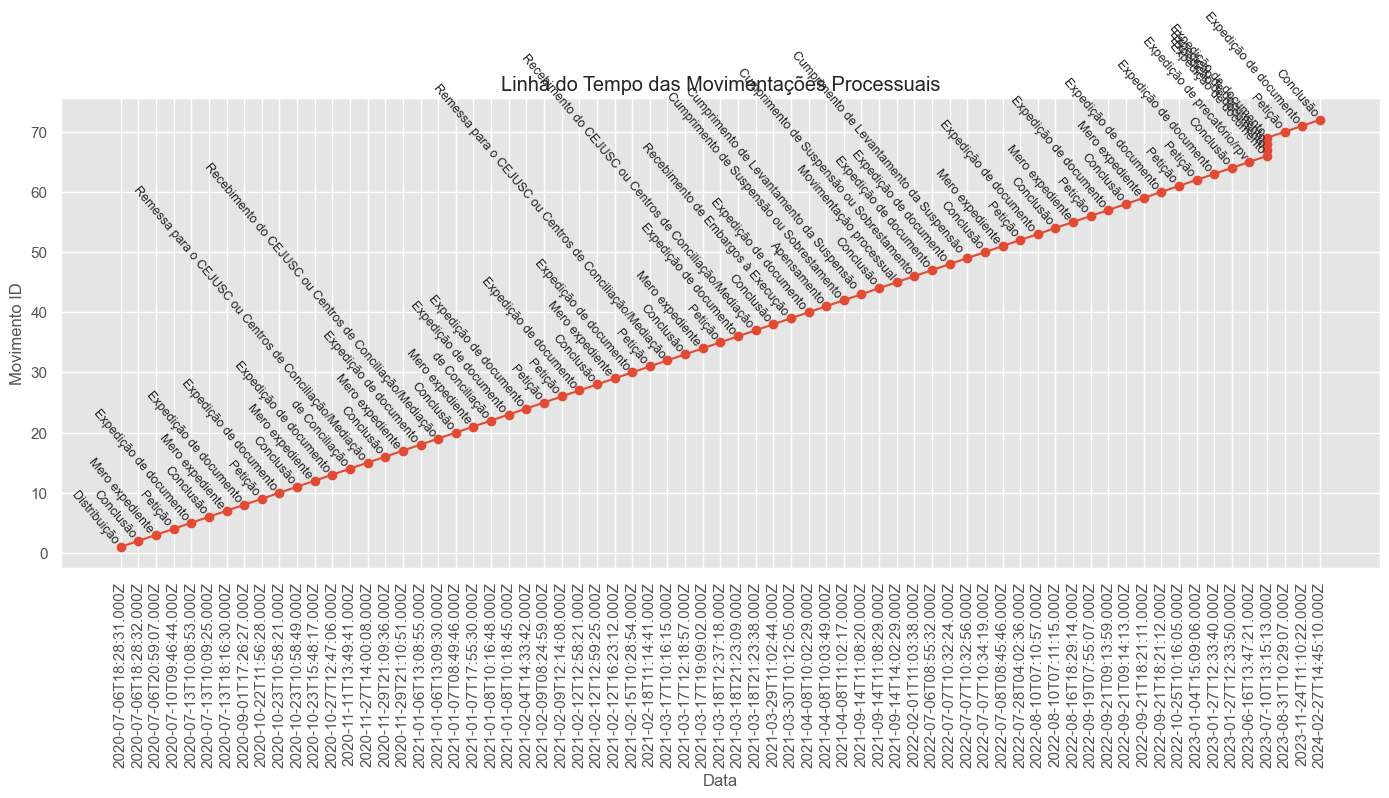

In [1365]:
# plotando gráfico de linha do tempo

df_movimentos.sort_values(by='data', inplace=True)

# Criando a linha do tempo
plt.figure(figsize=(14, 8))

# Adicionando uma coluna para identificar o número de movimentos
df_movimentos['movimento_id'] = range(1, len(df_movimentos) + 1)

# Plotando a linha do tempo
plt.plot(df_movimentos['data'], df_movimentos['movimento_id'], marker='o')

# Anotando cada ponto na linha do tempo
for i, row in df_movimentos.iterrows():
    plt.text(row['data'], row['movimento_id'], row['descricao_movimento'], fontsize=9, ha='right', va='bottom', rotation=-50)

# Configurando os rótulos e título do gráfico
plt.xlabel('Data')
plt.ylabel('Movimento ID')
plt.title('Linha do Tempo das Movimentações Processuais')
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [1366]:
# fomatação de data 

df_movimentos['data'] = pd.to_datetime(df_movimentos['data'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# SEGUNDA ETAPA
Julgados do mesmo órgão

In [1367]:
# obtendo código e nome do órgão julgador 

codigo = dados_dict['hits']['hits'][0]['_source']['orgaoJulgador']['codigo']
orgao_julgador = dados_dict['hits']['hits'][0]['_source']['orgaoJulgador']['nome']
orgao_julgador_original = orgao_julgador
classe_original = dados_dict['hits']['hits'][0]['_source']['classe']['nome']
assunto_original = dados_dict['hits']['hits'][0]['_source']['assuntos'][0]['nome']

print (f'Código: {codigo} - Órgão julgador: {orgao_julgador}')
orgao_julgador

Código: 78336 - Órgão julgador: CENTRO JUDICIÁRIO DE SOLUÇÃO DE CONFLITOS E CIDADANIA DA COMARCA DE ABREU E LIMA


'CENTRO JUDICIÁRIO DE SOLUÇÃO DE CONFLITOS E CIDADANIA DA COMARCA DE ABREU E LIMA'

In [1368]:
# requisitando

payload = json.dumps({
    "size": 10000,  # Aumentando o tamanho para obter todos os resultados
    "query": {
        "match": {"orgaoJulgador.codigo": codigo}  # Filtrando pelo código do órgão julgador
    },
    "sort": [{"dataAjuizamento": {"order": "desc"}}]  # Ordenando por data de ajuizamento
})

# Headers da requisição
headers = {
    'Authorization': api_key,
    'Content-Type': 'application/json'
}

# Realizando a requisição
response = requests.request("POST", url, headers=headers, data=payload)

In [1369]:
# iterando e inserindo os dados no data frame

# Verificando se a requisição foi bem sucedida
if response.status_code == 200:
    dados_dict = response.json()
    
    # Lista para armazenar os processos formatados
    processos = []
    
    # Iterando sobre os processos retornados
    for processo in dados_dict['hits']['hits']:
        numero_processo = processo['_source']['numeroProcesso']
        classe = processo['_source']['classe']['nome']
        assunto = ', '.join([assunto['nome'] for assunto in processo['_source']['assuntos']])
        data_ajuizamento = (processo['_source']['dataAjuizamento'])
        ultima_atualizacao = (processo['_source']['dataHoraUltimaAtualizacao'])
        formato = processo['_source']['formato']['nome']
        codigo = processo['_source']['orgaoJulgador']['codigo']
        orgao_julgador = processo['_source']['orgaoJulgador']['nome']
        municipio = processo['_source']['orgaoJulgador']['codigoMunicipioIBGE']
        grau = processo['_source'].get('grau')
        
        # Movimentos do processo
        movimentos = processo['_source'].get('movimentos', [])
        
        # Última movimentação
        if movimentos:
            ult_mov = movimentos[-1]
            situacao = ult_mov['nome']
            ultimo_mov = ult_mov['dataHora']
        else:
            ult_mov = None
            situacao = None
            ultimo_mov = None
        
        # Adicionando os dados formatados à lista de processos
        processos.append([
            numero_processo, classe, assunto, data_ajuizamento, ultima_atualizacao, formato,
            codigo, orgao_julgador, municipio, grau,
            movimentos, situacao, ultimo_mov
        ])
    
    # Criando o DataFrame
    df = pd.DataFrame(processos, columns=[
        'numero_processo', 'classe', 'assunto', 'data_ajuizamento', 'ultima_atualizacao',
        'formato', 'codigo', 'orgao_julgador', 'municipio', 'grau', 'movimentos', 'situacao', 'ultimo_mov'
    ])
    
    # Mostrando todas as linhas do DataFrame
    pd.set_option('display.max_rows', None)  # Mostrar todas as linhas do DataFrame 
    
else:
    print(f"Erro na requisição: {response.status_code} - {response.text}")

In [1370]:
df.head()

,numero_processo,classe,assunto,data_ajuizamento,ultima_atualizacao,formato,codigo,orgao_julgador,municipio,grau,movimentos,situacao,ultimo_mov
0,00018666320248172100,Homologação da Transação Extrajudicial,"Revisão, Regulamentação de Visitas",2024-06-05T00:00:00.000Z,2024-06-19T03:14:09.500Z,Eletrônico,78336,CENTRO JUDICIÁRIO DE SOLUÇÃO DE CONFLITOS E CIDADANIA DA COMARCA DE ABREU E LIMA,2600054,G1,"[{'complementosTabelados': [{'codigo': 2, 'valor': 2, 'nome': 'sorteio', 'descricao': 'tipo_de_distribuicao_redistribuicao'}], 'codigo': 26, 'nome': 'Distribuição', 'dataHora': '2024-06-05T11:46:31.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 9, 'nome': 'designada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-05T11:47:53.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 13, 'nome': 'realizada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-06T15:15:28.000Z'}, {'complementosTabelados': [{'codigo': 4, 'valor': 80, 'nome': 'Outros documentos', 'descricao': 'tipo_de_documento'}], 'codigo': 60, 'nome': 'Expedição de documento', 'dataHora': '2024-06-06T15:21:16.000Z'}, {'codigo': 14739, 'nome': 'Evolução da Classe Processual', 'dataHora': '2024-06-06T15:18:58.000Z'}]",Evolução da Classe Processual,2024-06-06T15:18:58.000Z
1,00018232920248172100,Reclamação Pré-processual,"Dissolução, Fixação",2024-06-03T00:00:00.000Z,2024-06-20T07:52:09.620Z,Eletrônico,78336,CENTRO JUDICIÁRIO DE SOLUÇÃO DE CONFLITOS E CIDADANIA DA COMARCA DE ABREU E LIMA,2600054,G1,"[{'complementosTabelados': [{'codigo': 2, 'valor': 2, 'nome': 'sorteio', 'descricao': 'tipo_de_distribuicao_redistribuicao'}], 'codigo': 26, 'nome': 'Distribuição', 'dataHora': '2024-06-03T12:43:26.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 9, 'nome': 'designada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-03T12:50:31.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 13, 'nome': 'realizada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-07T09:12:59.000Z'}, {'codigo': 246, 'nome': 'Definitivo', 'dataHora': '2024-06-07T09:15:11.000Z'}]",Definitivo,2024-06-07T09:15:11.000Z
2,00018224420248172100,Reclamação Pré-processual,Dissolução,2024-06-03T00:00:00.000Z,2024-06-19T03:39:08.751Z,Eletrônico,78336,CENTRO JUDICIÁRIO DE SOLUÇÃO DE CONFLITOS E CIDADANIA DA COMARCA DE ABREU E LIMA,2600054,G1,"[{'complementosTabelados': [{'codigo': 2, 'valor': 2, 'nome': 'sorteio', 'descricao': 'tipo_de_distribuicao_redistribuicao'}], 'codigo': 26, 'nome': 'Distribuição', 'dataHora': '2024-06-03T12:37:16.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 9, 'nome': 'designada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-03T12:48:57.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 14, 'nome': 'não-realizada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-07T09:06:22.000Z'}, {'codigo': 246, 'nome': 'Definitivo', 'dataHora': '2024-06-07T09:06:56.000Z'}]",Definitivo,2024-06-07T09:06:56.000Z
3,00018086020248172100,Homologação da Transação Extrajudicial,Dissolução,2024-06-03T00:00:00.000Z,2024-06-19T11:46:39.902Z,Eletrônico,78336,CENTRO JUDICIÁRIO DE SOLUÇÃO DE CONFLITOS E CIDADANIA DA COMARCA DE ABREU E LIMA,2600054,G1,"[{'complementosTabelados': [{'codigo': 2, 'valor': 2, 'nome': 'sorteio', 'descricao': 'tipo_de_distribuicao_redistribuicao'}], 'codigo': 26, 'nome': 'Distribuição', 'dataHora': '2024-06-03T09:11:42.000Z'}, {'complementosTabelados': [{'codigo': 4, 'valor': 107, 'nome': 'Certidão', 'descricao': 'tipo_de_documento'}], 'codigo': 60, 'nome': 'Expedição de documento', 'dataHora': '2024-06-03T09:23:13.000Z'}, {'complementosTabelados': [{'codigo': 3, 'valor': 36, 'nome': 'para julgamento', 'descricao'

# Limpeza dos Dados:

In [1371]:
# verificar o tipo das colunas

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   numero_processo     1440 non-null   object
 1   classe              1440 non-null   object
 2   assunto             1440 non-null   object
 3   data_ajuizamento    1440 non-null   object
 4   ultima_atualizacao  1440 non-null   object
 5   formato             1440 non-null   object
 6   codigo              1440 non-null   int64 
 7   orgao_julgador      1440 non-null   object
 8   municipio           1440 non-null   int64 
 9   grau                1440 non-null   object
 10  movimentos          1440 non-null   object
 11  situacao            1428 non-null   object
 12  ultimo_mov          1428 non-null   object
dtypes: int64(2), object(11)
memory usage: 146.4+ KB


* Existem alguns valores ausentes. Como são poucos, iremos excluir as linhas correspondentes.

In [1372]:
# verificar valores inexistentes ou nulos
# escluindo as linhas nulas

df.dropna(inplace=True)

In [1373]:
# há dados duplicados? 

duplicatas = df.duplicated(subset=['numero_processo'])
df_duplicatas = df[duplicatas]
print('Número de linhas duplicadas:', df_duplicatas['numero_processo'].count())

# excluir os duplicados do df original 

# df.drop_duplicates(inplace=True)

Número de linhas duplicadas: 37


In [1374]:
# vendo a quantidades de linhas que restou

df.shape

(1428, 13)

In [1375]:
# verificar a coluna grau, quantos valores há

df['grau'].value_counts()

G1    1428
Name: grau, dtype: int64

In [1376]:
# verificar a coluna municipio, quantos valores há

df['municipio'].value_counts()

2600054    1428
Name: municipio, dtype: int64

In [1377]:
# verificar a coluna codigo, quantos valores há

df['codigo'].value_counts()

78336    1428
Name: codigo, dtype: int64

In [1378]:
# verificar se há processo físico

df['formato'].value_counts()

Eletrônico    1038
Físico         390
Name: formato, dtype: int64

A depender do caso concreto:
* Se só existe um valor, ele nada nos diz, então iremos excluir essas colunas.
* Exceção para o caso dos processos físicos e eltrônicos, que são importantes para mais à frente serem trabalhados.

In [1379]:
# excluindo as colunas 

df.drop(columns=['grau', 'municipio', 'codigo'], inplace=True)

In [1380]:
# resetando o index



In [1381]:
# converter as datas para datatime
df['data_ajuizamento'] = pd.to_datetime(df['data_ajuizamento'])
df['ultimo_mov'] = pd.to_datetime(df['ultimo_mov'])
df['ultima_atualizacao'] = pd.to_datetime(df['ultima_atualizacao'])

In [1382]:
# visualizando após as alterações

df.head(1)

,numero_processo,classe,assunto,data_ajuizamento,ultima_atualizacao,formato,orgao_julgador,movimentos,situacao,ultimo_mov
0,00018666320248172100,Homologação da Transação Extrajudicial,"Revisão, Regulamentação de Visitas",2024-06-05 00:00:00+00:00,2024-06-19 03:14:09.500000+00:00,Eletrônico,CENTRO JUDICIÁRIO DE SOLUÇÃO DE CONFLITOS E CIDADANIA DA COMARCA DE ABREU E LIMA,"[{'complementosTabelados': [{'codigo': 2, 'valor': 2, 'nome': 'sorteio', 'descricao': 'tipo_de_distribuicao_redistribuicao'}], 'codigo': 26, 'nome': 'Distribuição', 'dataHora': '2024-06-05T11:46:31.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 9, 'nome': 'designada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-05T11:47:53.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 13, 'nome': 'realizada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-06T15:15:28.000Z'}, {'complementosTabelados': [{'codigo': 4, 'valor': 80, 'nome': 'Outros documentos', 'descricao': 'tipo_de_documento'}], 'codigo': 60, 'nome': 'Expedição de documento', 'dataHora': '2024-06-06T15:21:16.000Z'}, {'codigo': 14739, 'nome': 'Evolução da Classe Processual', 'dataHora': '2024-06-06T15:18:58.000Z'}]",Evolução da Classe Processual,2024-06-06 15:18:58+00:00


In [1383]:
# transformar as colunas em formatos melhores de se trabalhar

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   numero_processo     1428 non-null   object             
 1   classe              1428 non-null   object             
 2   assunto             1428 non-null   object             
 3   data_ajuizamento    1428 non-null   datetime64[ns, UTC]
 4   ultima_atualizacao  1428 non-null   datetime64[ns, UTC]
 5   formato             1428 non-null   object             
 6   orgao_julgador      1428 non-null   object             
 7   movimentos          1428 non-null   object             
 8   situacao            1428 non-null   object             
 9   ultimo_mov          1428 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), object(7)
memory usage: 122.7+ KB


In [1384]:
pd.set_option('display.max_columns', None)  # Mostra todas as colunas
pd.set_option('display.max_colwidth', None)  # Largura máxima das colunas

df.iloc[0]

numero_processo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   00018666320248172100
classe                                                           

In [1385]:
# converter as strings para minúsculas 

colunas = ['classe', 'assunto', 'formato', 'orgao_julgador', 'situacao']

for coluna in colunas:
    df[coluna] = df[coluna].str.lower()

# Atenção:

Aqui, vamos calcular, em dias:
- Em quanto tempo o processo foi resolvido, estando com baixa definitiva ou arquivado definitivamente, subtraindo a data do último movimento pela data do ajuizamento;
- Por quanto tempo o processo não julgado está tramitando. Nesse caso, o cálculo é diferente, pois considera, ao invés da data do último movimento, a data atual.  

In [1386]:
# Convertendo as colunas de data para datetime
df['data_ajuizamento'] = pd.to_datetime(df['data_ajuizamento'])
df['ultimo_mov'] = pd.to_datetime(df['ultimo_mov'])
df['ultima_atualizacao'] = pd.to_datetime(df['ultima_atualizacao'])

# Função para calcular contagem de dias conforme a situação
def calcular_contagem_dias(row):
    # Verificar se as datas são tz-aware ou tz-naive
    if row['ultimo_mov'].tzinfo is None:
        row['ultimo_mov'] = row['ultimo_mov'].tz_localize('UTC')
    if row['data_ajuizamento'].tzinfo is None:
        row['data_ajuizamento'] = row['data_ajuizamento'].tz_localize('UTC')
        
    if 'definitivo' in row['situacao'].lower() or 'baixa definitiva' in row['situacao'].lower():
        return (row['ultimo_mov'] - row['data_ajuizamento']).days
    else:
        return (pd.Timestamp.now(tz='UTC') - row['data_ajuizamento']).days

# Aplicar a função usando apply
df['contagem_dias'] = df.apply(calcular_contagem_dias, axis=1)

# Média de tempo para julgar (geral)
media_tempo_geral = df['contagem_dias'].mean().astype(int)

# Média de tempo para julgar por assunto
media_tempo_por_assunto = df.groupby('assunto')['contagem_dias'].mean().astype(int)

# Média de tempo para julgar por classe
media_tempo_por_classe = df.groupby('classe')['contagem_dias'].mean().astype(int)

In [1387]:
df.head(4)

,numero_processo,classe,assunto,data_ajuizamento,ultima_atualizacao,formato,orgao_julgador,movimentos,situacao,ultimo_mov,contagem_dias
0,00018666320248172100,homologação da transação extrajudicial,"revisão, regulamentação de visitas",2024-06-05 00:00:00+00:00,2024-06-19 03:14:09.500000+00:00,eletrônico,centro judiciário de solução de conflitos e cidadania da comarca de abreu e lima,"[{'complementosTabelados': [{'codigo': 2, 'valor': 2, 'nome': 'sorteio', 'descricao': 'tipo_de_distribuicao_redistribuicao'}], 'codigo': 26, 'nome': 'Distribuição', 'dataHora': '2024-06-05T11:46:31.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 9, 'nome': 'designada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-05T11:47:53.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 13, 'nome': 'realizada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-06T15:15:28.000Z'}, {'complementosTabelados': [{'codigo': 4, 'valor': 80, 'nome': 'Outros documentos', 'descricao': 'tipo_de_documento'}], 'codigo': 60, 'nome': 'Expedição de documento', 'dataHora': '2024-06-06T15:21:16.000Z'}, {'codigo': 14739, 'nome': 'Evolução da Classe Processual', 'dataHora': '2024-06-06T15:18:58.000Z'}]",evolução da classe processual,2024-06-06 15:18:58+00:00,21
1,00018232920248172100,reclamação pré-processual,"dissolução, fixação",2024-06-03 00:00:00+00:00,2024-06-20 07:52:09.620000+00:00,eletrônico,centro judiciário de solução de conflitos e cidadania da comarca de abreu e lima,"[{'complementosTabelados': [{'codigo': 2, 'valor': 2, 'nome': 'sorteio', 'descricao': 'tipo_de_distribuicao_redistribuicao'}], 'codigo': 26, 'nome': 'Distribuição', 'dataHora': '2024-06-03T12:43:26.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 9, 'nome': 'designada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-03T12:50:31.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 13, 'nome': 'realizada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-07T09:12:59.000Z'}, {'codigo': 246, 'nome': 'Definitivo', 'dataHora': '2024-06-07T09:15:11.000Z'}]",definitivo,2024-06-07 09:15:11+00:00,4
2,00018224420248172100,reclamação pré-processual,dissolução,2024-06-03 00:00:00+00:00,2024-06-19 03:39:08.751000+00:00,eletrônico,centro judiciário de solução de conflitos e cidadania da comarca de abreu e lima,"[{'complementosTabelados': [{'codigo': 2, 'valor': 2, 'nome': 'sorteio', 'descricao': 'tipo_de_distribuicao_redistribuicao'}], 'codigo': 26, 'nome': 'Distribuição', 'dataHora': '2024-06-03T12:37:16.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 9, 'nome': 'designada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-03T12:48:57.000Z'}, {'complementosTabelados': [{'codigo': 15, 'valor': 14, 'nome': 'não-realizada', 'descricao': 'situacao_da_audiencia'}], 'codigo': 12740, 'nome': 'de Conciliação', 'dataHora': '2024-06-07T09:06:22.000Z'}, {'codigo': 246, 'nome': 'Definitivo', 'dataHora': '2024-06-07T09:06:56.000Z'}]",definitivo,2024-06-07 09:06:56+00:00,4
3,00018086020248172100,homologação da transação extrajudicial,dissolução,2024-06-03 00:00:00+00:00,2024-06-19 11:46:39.902000+00:00,eletrônico,centro judiciário de solução de conflitos e cidadania da comarca de abreu e lima,"[{'complementosTabelados': [{'codigo': 2, 'valor': 2, 'nome': 'sorteio', 'descricao': 'tipo_de_distribuicao_redistribuicao'}], 'codigo': 26, 'nome': 'Distribuição', 'dataHora': '2024-06-03T09:11:42.000Z'}, {'complementosTabelados': [{'codigo': 4, 'valor': 107, 'nome': 'Certidão', 'descricao': 'tipo_de_documento'}], 'codigo': 60, 'nome': 'Expedição de documento', 'dataHora': '2024-06-03T09:23:13.000Z'}, {'complementosTabelados': [{'codigo': 3, 'valor': 36, 'nome': 'para julgamento', 'descricao': 'tipo_de_conclusao'}], 'codi

# Etapa de Análise

In [1388]:
# resultados mais comuns na situação 

df['situacao'].value_counts()

terminado = ['definitivo', 'baixa definitiva', 'baixa', 'improcedência', 'procedência', 'procedência em parte', 'incompetência', 
       'extinção da execução ou do cumprimento da sentença', 'prescrição intercorrente', 'ausência de pressupostos processuais',
       'ausência das condições da ação', 'desistência', 'abandono da causa']

In [1389]:
# convertendo em dt para manipular mais à frente

df['data_ajuizamento'] = pd.to_datetime(df['data_ajuizamento'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df['ultima_atualizacao'] = pd.to_datetime(df['ultima_atualizacao'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df['ultimo_mov'] = pd.to_datetime(df['ultimo_mov'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

In [1390]:
# Converter a lista terminado para um conjunto (set) para melhor performance na verificação
terminado_set = set(terminado)

# Filtrar o DataFrame para obter somente os processos julgados
df_julgados = df[df['situacao'].apply(lambda x: any(term in x.lower() for term in terminado_set))]

# Filtrar o DataFrame para obter somente os processos não julgados
df_nao_julgados = df[~df['situacao'].apply(lambda x: any(term in x.lower() for term in terminado_set))]

In [1391]:
# processo mais antigo do df
df.iloc[-1].head()

numero_processo                   00010408220088170100
classe                                      inventário
assunto                            arrolamento de bens
data_ajuizamento             2008-06-09 00:00:00+00:00
ultima_atualizacao    2023-01-15 04:46:14.496000+00:00
Name: 1439, dtype: object

In [1392]:
# processo mais antigo encontrado julgado
df_julgados.iloc[-1].head()

numero_processo                   00010165320178172100
classe                        procedimento comum cível
assunto                  defeito, nulidade ou anulação
data_ajuizamento             2017-06-13 00:00:00+00:00
ultima_atualizacao    2022-09-05 19:44:49.563000+00:00
Name: 1427, dtype: object

In [1393]:
# processo mais antigo SEM julgamento
df_nao_julgados.iloc[-1].head()

numero_processo                   00010408220088170100
classe                                      inventário
assunto                            arrolamento de bens
data_ajuizamento             2008-06-09 00:00:00+00:00
ultima_atualizacao    2023-01-15 04:46:14.496000+00:00
Name: 1439, dtype: object

In [1394]:
# qual a porcentagem de processos físicos?
porcentagem_processos_fisicos = (len(df[df['formato'] == 'físico']) / len(df)) * 100
print(f"Porcentagem de processos físicos: {porcentagem_processos_fisicos:.2f}%")

Porcentagem de processos físicos: 27.31%


In [1395]:
# processos não julgados/julgados - comparativo/proporção

# quantidade
quantidade_julgados = len(df_julgados)
quantidade_nao_julgados = len(df_nao_julgados)
total_processos = len(df)

# porcentagem
porcentagem_julgados = (quantidade_julgados / total_processos) * 100
porcentagem_nao_julgados = (quantidade_nao_julgados / total_processos) * 100

# retornos
print(f"Quantidade de processos julgados: {quantidade_julgados}")
print(f"Porcentagem de processos julgados: {porcentagem_julgados:.2f}%")
print(f"Quantidade de processos não julgados: {quantidade_nao_julgados}")
print(f"Porcentagem de processos não julgados: {porcentagem_nao_julgados:.2f}%")

Quantidade de processos julgados: 949
Porcentagem de processos julgados: 66.46%
Quantidade de processos não julgados: 479
Porcentagem de processos não julgados: 33.54%


In [1396]:
# quantidade de processos ajuizados em cada ano x julgados

# ajuizados por ano
df['ano_ajuizamento'] = df['data_ajuizamento'].dt.year
ajuizados_por_ano = df['ano_ajuizamento'].value_counts().sort_index().rename_axis('ano').reset_index(name='quantidade_ajuizados')

# julgados por ano
df_julgados['ano_ajuizamento'] = df_julgados['data_ajuizamento'].dt.year
julgados_por_ano = df_julgados['ano_ajuizamento'].value_counts().sort_index().rename_axis('ano').reset_index(name='quantidade_julgados')

# junção dos dois df
comparativo_ano = pd.merge(ajuizados_por_ano, julgados_por_ano, on='ano', how='left').fillna(0)

print("Quantidade de processos ajuizados e julgados por ano:")
comparativo_ano

Quantidade de processos ajuizados e julgados por ano:


C:\Users\thiag\AppData\Local\Temp\ipykernel_5612\3746094335.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_julgados['ano_ajuizamento'] = df_julgados['data_ajuizamento'].dt.year


,ano,quantidade_ajuizados,quantidade_julgados
0,2008,1,0.0
1,2012,1,0.0
2,2013,2,0.0
3,2016,4,0.0
4,2017,13,2.0
5,2018,18,11.0
6,2019,99,85.0
7,2020,345,296.0
8,2021,257,156.0
9,2022,212,149.0


In [1397]:
# marcar os processos julgados
df['julgado'] = df['situacao'].apply(lambda x: any(term in x.lower() for term in terminado))

# Gráficos 

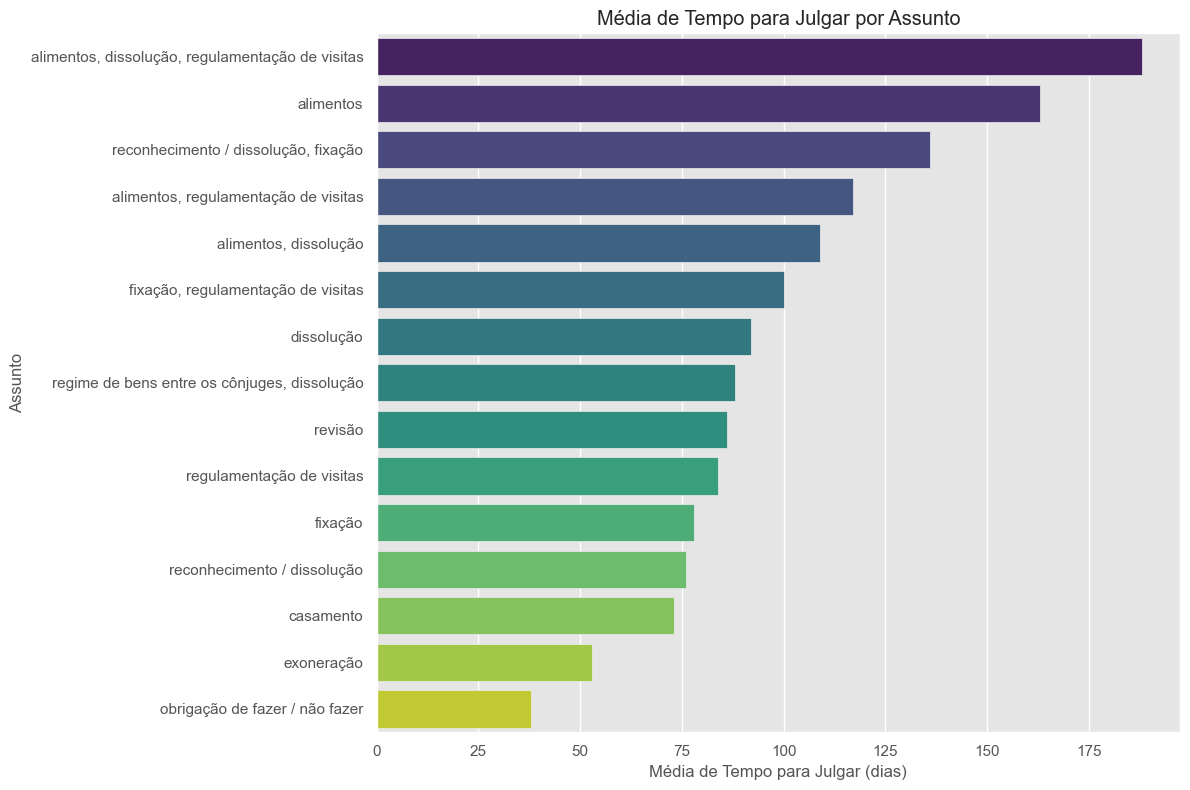

In [1398]:
# Contagem dos assuntos mais frequentes
assuntos_frequentes = df_julgados['assunto'].value_counts().head(15)

# Média de tempo para julgar por assunto
media_tempo_por_assunto = df_julgados.groupby('assunto')['contagem_dias'].mean().astype(int)

# Selecionar apenas os assuntos mais frequentes
media_tempo_por_assunto = media_tempo_por_assunto.loc[assuntos_frequentes.index]

# Ordenar para melhor visualização
media_tempo_por_assunto = media_tempo_por_assunto.sort_values(ascending=False)

# Plotar o gráfico de barras verticais
plt.figure(figsize=(12, 8))
sns.barplot(x=media_tempo_por_assunto.values, y=media_tempo_por_assunto.index, palette='viridis')
plt.xlabel('Média de Tempo para Julgar (dias)')
plt.ylabel('Assunto')
plt.title('Média de Tempo para Julgar por Assunto')
plt.tight_layout()
plt.show()

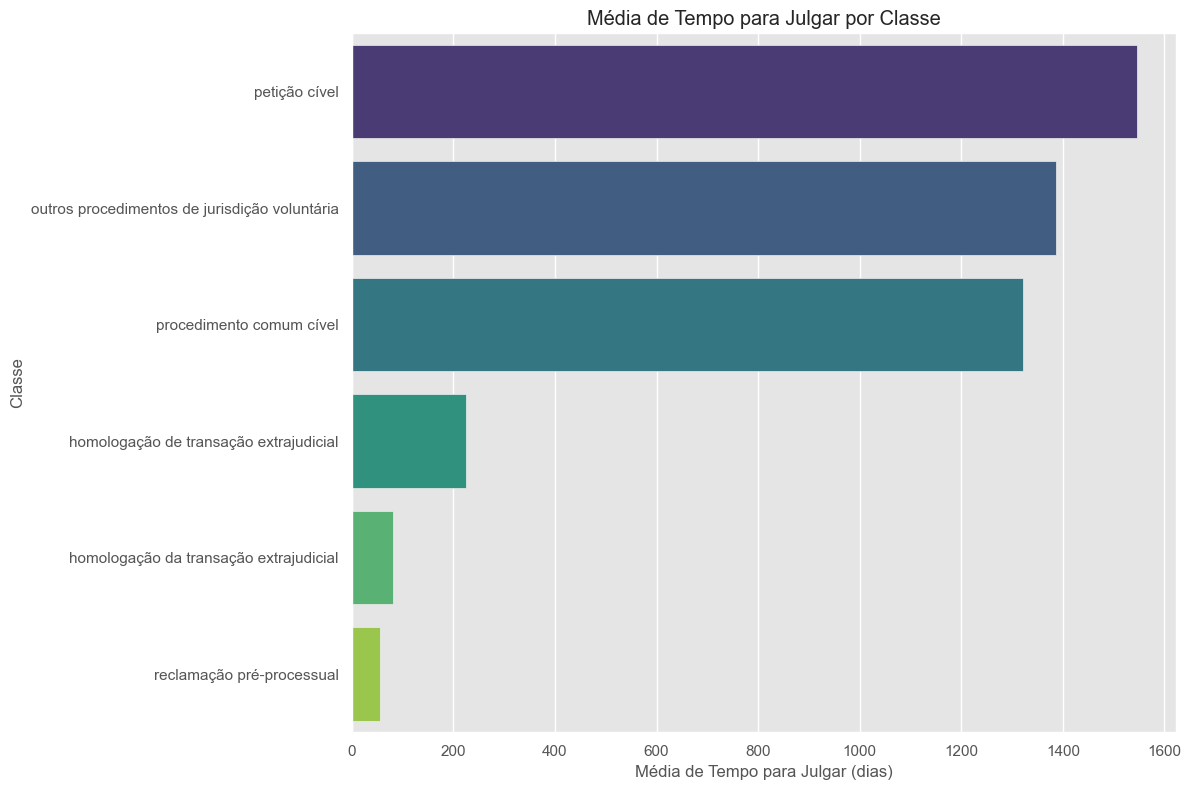

In [1399]:
# Contagem das classes mais frequentes
classes_frequentes = df_julgados['classe'].value_counts().head(15)

# Média de tempo para julgar por classe
media_tempo_por_classe = df_julgados.groupby('classe')['contagem_dias'].mean().astype(int)

# Selecionar apenas as classes mais frequentes
media_tempo_por_classe = media_tempo_por_classe.loc[classes_frequentes.index]

# Ordenar para melhor visualização
media_tempo_por_classe = media_tempo_por_classe.sort_values(ascending=False)

# Plotar o gráfico de barras verticais
plt.figure(figsize=(12, 8))
sns.barplot(x=media_tempo_por_classe.values, y=media_tempo_por_classe.index, palette='viridis')
plt.xlabel('Média de Tempo para Julgar (dias)')
plt.ylabel('Classe')
plt.title('Média de Tempo para Julgar por Classe')
plt.tight_layout()
plt.show()

In [1400]:
julgados_por_ano.head()

,ano,quantidade_julgados
0,2017,2
1,2018,11
2,2019,85
3,2020,296
4,2021,156


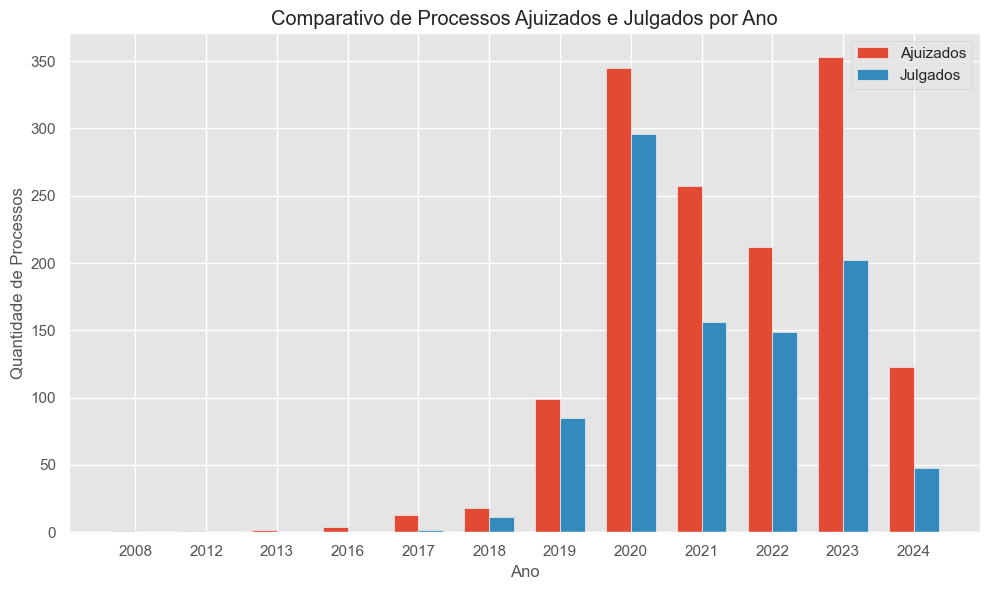

In [1401]:
# Quantidade de processos ajuizados e julgados por ano

comparativo_ano_df = pd.DataFrame(comparativo_ano)

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = comparativo_ano_df.index

bar1 = plt.bar(index - bar_width/2, comparativo_ano_df['quantidade_ajuizados'], bar_width, label='Ajuizados')
bar2 = plt.bar(index + bar_width/2, comparativo_ano_df['quantidade_julgados'], bar_width, label='Julgados')

plt.xlabel('Ano')
plt.ylabel('Quantidade de Processos')
plt.title('Comparativo de Processos Ajuizados e Julgados por Ano')
plt.xticks(index, comparativo_ano_df['ano'])
plt.legend()

plt.tight_layout()
plt.show()

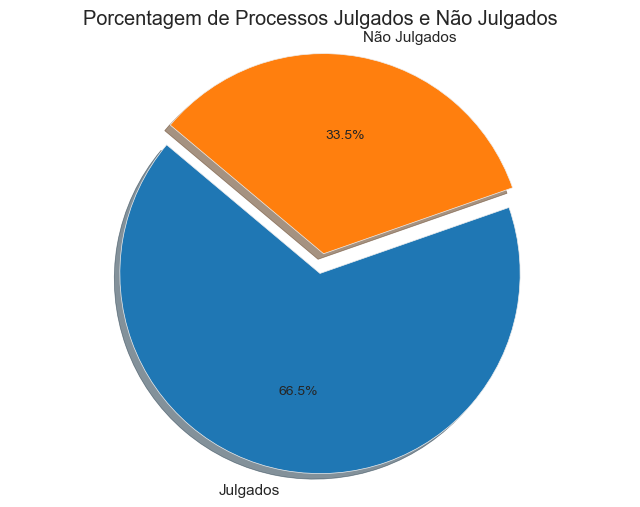

In [1402]:
# Gráfico de pizza: porcentagem de processos julgados/não julgados

# Contagem de processos julgados e não julgados
contagem_julgados = df[df['julgado']]['numero_processo'].count()
contagem_nao_julgados = df[~df['julgado']]['numero_processo'].count()

# Preparar os dados para o gráfico de pizza
labels = ['Julgados', 'Não Julgados']
sizes = [contagem_julgados, contagem_nao_julgados]
colors = ['#1f77b4', '#ff7f0e']
explode = (0.1, 0)  # explode 1st slice (Julgados)

# Plotar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Porcentagem de Processos Julgados e Não Julgados')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

C:\Users\thiag\AppData\Local\Temp\ipykernel_5612\3932987819.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_julgados['tempo_para_julgar'] = (df_julgados['ultimo_mov'] - df_julgados['data_ajuizamento']).dt.days


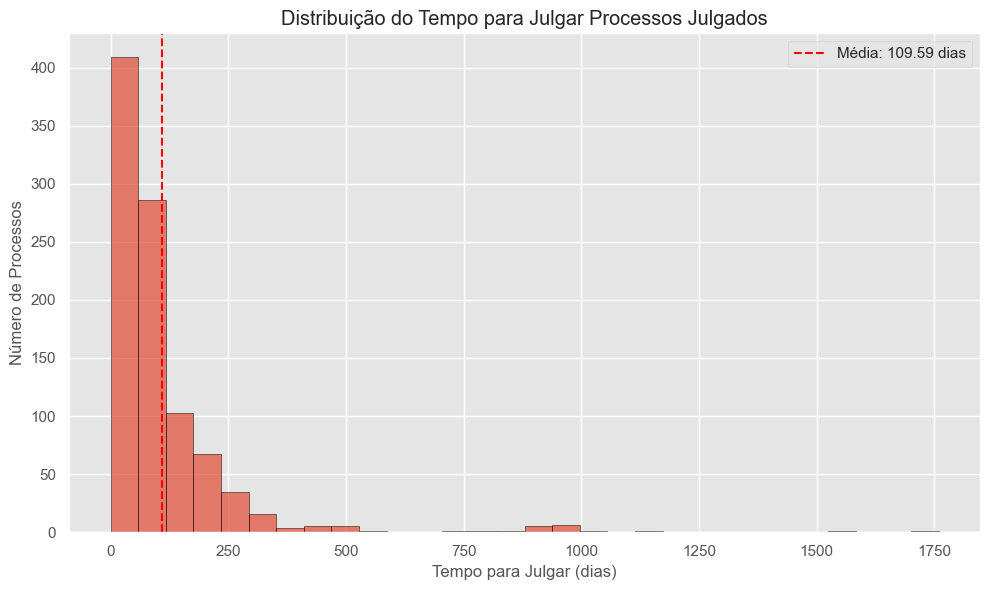

In [1403]:
# Histograma: processos julgados x tempo para julgar (dias), com linha de média
# Filtrar apenas os processos julgados

df_julgados = df[df['julgado']]

# Calcular tempo para julgar em dias
df_julgados['tempo_para_julgar'] = (df_julgados['ultimo_mov'] - df_julgados['data_ajuizamento']).dt.days

# Calcular média de tempo para julgar
media_tempo_para_julgar = df_julgados['tempo_para_julgar'].mean()

# Plotar o histograma
plt.figure(figsize=(10, 6))
plt.hist(df_julgados['tempo_para_julgar'], bins=30, edgecolor='black', alpha=0.7)

# Adicionar linha de média
plt.axvline(media_tempo_para_julgar, color='red', linestyle='dashed', linewidth=1.5, label=f'Média: {media_tempo_para_julgar:.2f} dias')

plt.title('Distribuição do Tempo para Julgar Processos Julgados')
plt.xlabel('Tempo para Julgar (dias)')
plt.ylabel('Número de Processos')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


In [1404]:
# frequência de tipo

linha = df[df['numero_processo'] == numero_processo_original]
linha_dias = linha['contagem_dias'].iloc[0]
media_tempo_por_assunto

alimentos, dissolução, regulamentação de visitas    188
alimentos                                           163
reconhecimento / dissolução, fixação                136
alimentos, regulamentação de visitas                117
alimentos, dissolução                               109
fixação, regulamentação de visitas                  100
dissolução                                           92
regime de bens entre os cônjuges, dissolução         88
revisão                                              86
regulamentação de visitas                            84
fixação                                              78
reconhecimento / dissolução                          76
casamento                                            73
exoneração                                           53
obrigação de fazer / não fazer                       38
Name: contagem_dias, dtype: int32

In [1405]:
# data frame com diversas informações
# do caso concreto e das estatísticas relacionadas

In [1439]:
# tempo do processo até agora x o tempo médio
data_hoje = data_hoje.replace('-', '_')
data_hoje = str(data_hoje)

# Salvar em Excel

In [1443]:
# Converter as datas para strings sem fuso horário
df['data_ajuizamento'] = df['data_ajuizamento'].dt.strftime('%d-%m-%Y')  # Ajuste o formato conforme necessário
df['ultimo_mov'] = df['ultimo_mov'].dt.strftime('%d-%m-%Y')  # Ajuste o formato conforme necessário
df['ultima_atualizacao'] = df['ultima_atualizacao'].dt.strftime('%d-%m-%Y')  # Ajuste o formato conforme necessário


# Remover informações de fuso horário se necessário
#df['data_coluna'] = df['data_coluna'].dt.tz_localize(None)

# Definindo o nome do arquivo de saída com a data de hoje
data_hoje = datetime.now().strftime('%d_%m_%Y')
nome_arquivo = f'{numero_processo_original}_{orgao_julgador_original}_{data_hoje}.xlsx'

# Criando um objeto ExcelWriter
writer = pd.ExcelWriter(nome_arquivo, engine='xlsxwriter')

# Salvando o DataFrame df na primeira aba
df.to_excel(writer, sheet_name='Dados dos Processos', index=False)

# Salvando o DataFrame df_movimentos na segunda aba
df_movimentos.to_excel(writer, sheet_name='Movimentos Processuais', index=False)

# Salvando media_tempo_por_assunto em uma aba
media_tempo_por_assunto.to_excel(writer, sheet_name='Assuntos', index=False)

# Salvando media_tempo_por_classe em outra aba
media_tempo_por_classe.to_excel(writer, sheet_name='Classes', index=False)

# Fechando o ExcelWriter e salvando o arquivo
writer.save()

print(f'Dados salvos em "{nome_arquivo}" com sucesso.')


C:\Users\thiag\AppData\Local\Temp\ipykernel_5612\3910924962.py:30: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


Dados salvos em "00009272520208172100_CENTRO JUDICIÁRIO DE SOLUÇÃO DE CONFLITOS E CIDADANIA DA COMARCA DE ABREU E LIMA_26_06_2024.xlsx" com sucesso.
